# ERSP calculations test on artificial signals

## Table of Contents

* [Import libraries](#import)
* [Initialization](#init)
    * [Ensure that the root directory is the project directory](#directory)
    * [Generate signals](#gen)
        * [Store signals](#storesignals)
        * [Define markers](#markers)
    * [Generate noise](#noise)
        * [Plot noise](#noiseplot)
        * [Add noise to signals](#addnoise)
    * [Signal selector and time plot](#timeplot)
    * [Time and frequency plot (FFT)](#fftplot)
* [1-PSD around markers and ratio calculation : Old method](#old)
    * [Compute the PSDs around all markers for all signals](#psdsold)
    * [Plot signal i's PSDs around 1st marker 111](#psdplotold)
    * [Plot signal i's ERSP around 1st marker 111](#ERSPplotold)
    * [Analysis](#analysisold)
* [2-PSD around markers and ratio calculation: New method](#new)
    * [Compute the PSDs around all markers for one signal](#psdnew)
    * [Select PSD results around selected marker for one signal](#selectpsd)
    * [Plot signal i's PSDs around selected marker](#psdplotnew)
    * [Analysis 1](#analysis1new)
    * [Plot Signal i's ERSP around 1st marker 111](#ERSPnew)
    * [Analysis 2](#analysis2new)



## Import libraries<a name="import"></a>

In [32]:
import os
import pyxdf # xdf file importation
import matplotlib.pyplot as plt
import numpy as np
from my_functions import *
# library for creating filters
from scipy.signal import butter, iirnotch, filtfilt, welch
#%matplotlib widget

In [33]:
plt.close("all")  # close all figure windows

## Initialization <a   name="init"></a>

### Ensure that the root directory is the project directory <a   name="directory"></a>
In some cases, the root directory may not be the project directory. This is usually the case when the notebook is run from a subdirectory of the project directory.

In [34]:
# if pwd is SRC  change to root
print("Current working directory: ", os.getcwd())
if os.path.basename(os.getcwd()) == "SRC":
    os.chdir("..")
print("Current working directory: ", os.getcwd())
print(os.path.basename(os.getcwd()))

Current working directory:  c:\Users\iWiss\Documents\GitHub\Stage_Signal_Physio
Current working directory:  c:\Users\iWiss\Documents\GitHub\Stage_Signal_Physio
Stage_Signal_Physio


### Generate signals <a   name="gen"></a>

Generation of 3 sinusoidal signals of different frequencies but same duration and sampling frequency.
For both, the amplitude change at mid length (time).

- Signal 1 (F=12Hz) starts with an amplitude of  100 (A.U) and change to 10.
- Signal 2 (F=20Hz) starts with an amplitude of 20(A.U) and change to 10
- Signal 3 is a combination of signal 1 and 3

In [35]:
#Signal generation (2 signals)
Srate=500
length_time=20
change_time=length_time/2

signal_frequency1=12
signal_frequency2=20
signal_frequency3="12 + 20 "

original_amp_1=100
new_amp_1=original_amp_1/10
#new_amp_1=original_amp_1

original_amp_2=20
new_amp_2=original_amp_2/2


times,signal_amplitudes1=generate_sine_wave(amplitude=original_amp_1, frequency=signal_frequency1, duration=length_time, 
                               change_time=change_time, new_amplitude=new_amp_1, sample_rate=Srate)
print(np.shape(signal_amplitudes1))
times2,signal_amplitudes2=generate_sine_wave(amplitude=original_amp_2, frequency=signal_frequency2, duration=length_time, 
                               change_time=change_time, new_amplitude=new_amp_2, sample_rate=Srate)

signal_mixed_amplitudes=signal_amplitudes1+signal_amplitudes2

print(times[3500])
print(len(times))


(10000,)
7.0
10000


#### Store signals <a   name="storesignals"></a>

In [36]:
#stacking the signals as columns of a single 2D array (to be able to use the nearest_timestamps_array_finder and compute_lagged_psd2_all_electrodes functions)
signal_electrodes=np.column_stack((signal_amplitudes1,signal_amplitudes2,signal_mixed_amplitudes)) 
print(signal_electrodes.shape)

(10000, 3)


#### Define markers <a   name="markers"></a>

Creation of an array of markers and their timestamps as  list of tuples (timestamp,"marker_name") representing the onset of an event.
- This will serve as reference to PSD calculations.
- Here only the marker (111) corresponds to an event (amplitude change) at mid-duration.


In [37]:
#create table of event markers and their timestamps
#marker_timestamps=np.array([(change_time-3,100),(change_time,111),(change_time+3,100),(change_time+6,111)])
marker_timestamps=np.array([(change_time-5,100),(change_time,111),(change_time+5,100)])

### Generate noise <a   name="noise"></a>

In [38]:
#Generate noise
noise=np.random.uniform(low=-3,high=3,size=(len(signal_amplitudes1),1))
print(np.shape(noise))
noise_fftfreqs,noise_fft_magnitudes=fft_compute_on_single_channel2(signal=noise,Fs=Srate)


(10000, 1)


#### Plot noise <a   name="noiseplot"></a>

Text(0.5, 0.98, 'Noise signal: Time plot and FFT')

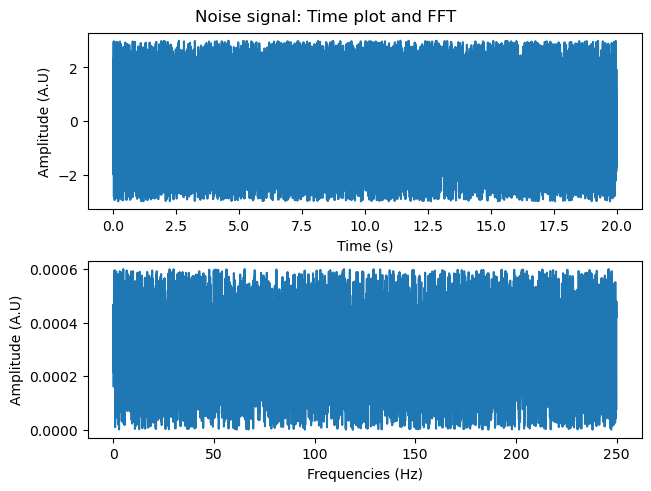

In [39]:
figure,axis=plt.subplots(2,num=1,layout="constrained")
axis[0].plot(times,noise)
axis[0].set_ylabel("Amplitude (A.U)")
axis[0].set_xlabel("Time (s)")

axis[1].plot(noise_fftfreqs,noise_fft_magnitudes)
axis[1].set_ylabel("Amplitude (A.U)")
axis[1].set_xlabel("Frequencies (Hz)")
figure.suptitle("Noise signal: Time plot and FFT")


#### Add noise to signals <a   name="addnoise"></a>

In [40]:
#Add noise to signals
noise_button=True
if noise_button is True:
    signal_electrodes=signal_electrodes+noise

### Signal selector and time plot <a   name="timeplot"></a>

In [41]:
#select the signal [1,3]
ELECTRODE_NUM=1
SELECTOR=ELECTRODE_NUM-1 #Due to python indices

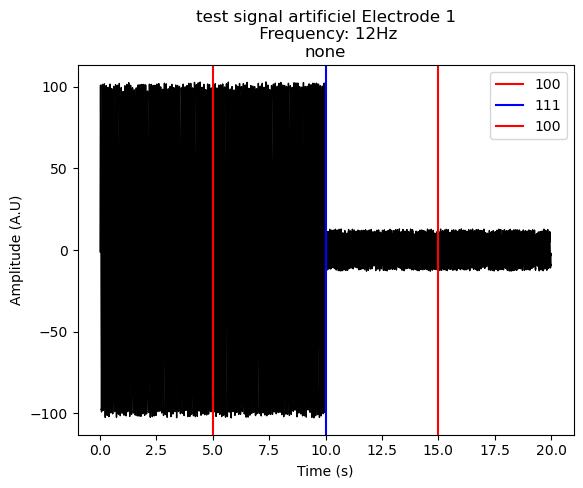

In [42]:
#Plot time signal i and the event markers
single_plot(filename="none",fig_number=2,x=times,y=signal_electrodes[:,SELECTOR],markers_times_array=marker_timestamps,
            fig_title="test signal artificiel Electrode "+str(ELECTRODE_NUM)+"\n Frequency: "+ str(eval("signal_frequency"+str(ELECTRODE_NUM)))+"Hz",
            xlabel="Time (s)",ylabel="Amplitude (A.U)")

### Time and frequency plot (FFT) <a   name="fftplot"></a>

In [43]:
FFT_whole_signals=compute_fft_on_all_channels2(channels_signals=signal_electrodes,Fs=Srate)
FFT_first_half_signals=compute_fft_on_all_channels2(channels_signals=signal_electrodes[0:(len(signal_electrodes)//2)+1],Fs=Srate)
FFT_second_half_signals=compute_fft_on_all_channels2(channels_signals=signal_electrodes[(len(signal_electrodes)//2):],Fs=Srate)

Text(0.5, 0, 'Frequencies (Hz)')

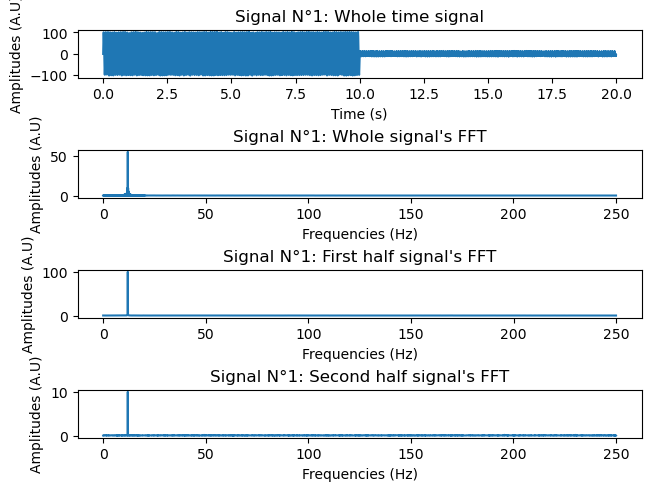

In [44]:
figure,axis=plt.subplots(4,num=3,layout="constrained")
axis[0].set_title("Signal N°"+str(ELECTRODE_NUM)+": Whole time signal")
axis[0].plot(times,signal_electrodes[:,SELECTOR])
axis[0].set_ylabel("Amplitudes (A.U)")
axis[0].set_xlabel("Time (s)")

axis[1].set_title("Signal N°"+str(ELECTRODE_NUM)+": Whole signal's FFT")
axis[1].plot(FFT_whole_signals["FFT_frequencies"][:,SELECTOR],FFT_whole_signals["FFT_magnitudes"][:,SELECTOR])
axis[1].set_ylabel("Amplitudes (A.U)")
axis[1].set_xlabel("Frequencies (Hz)")

axis[2].set_title("Signal N°"+str(ELECTRODE_NUM)+": First half signal's FFT")
axis[2].plot(FFT_first_half_signals["FFT_frequencies"][:,SELECTOR],FFT_first_half_signals["FFT_magnitudes"][:,SELECTOR])
axis[2].set_ylabel("Amplitudes (A.U)")
axis[2].set_xlabel("Frequencies (Hz)")

axis[3].set_title("Signal N°"+str(ELECTRODE_NUM)+": Second half signal's FFT")
axis[3].plot(FFT_second_half_signals["FFT_frequencies"][:,SELECTOR],FFT_second_half_signals["FFT_magnitudes"][:,SELECTOR])
axis[3].set_ylabel("Amplitudes (A.U)")
axis[3].set_xlabel("Frequencies (Hz)")


## 1-PSD around markers and ratio calculation : Old method<a   name="old"></a>

### Compute the PSDs around all markers for all signals<a   name="psdsold"></a>

In [45]:
#Find the nearest signal timepoint for each marker (timestamps,markers) (in case a marker is between two sample)
#returns a 2d array (Timestamp_indices,timestamps)
nearest_marker_indices_timestamps = nearest_timestamps_array_finder(
    times, marker_timestamps) 
print(type(nearest_marker_indices_timestamps[0,0]))

MARKERS LEN: 3
<class 'numpy.float64'>


In [46]:
# Segment length of the signal on which the PSD is computed (expressed in seconds)
TIME_WINDOW=1  #in seconds

In [47]:
#Compute PSD before all markers over all electrodes
tridi_freqs_before, tridi_Pxx_densities_before = compute_lagged_psd2_all_electrodes(signal_electrodes, Srate, nearest_marker_indices_timestamps,
                                                                                    time_lag=TIME_WINDOW, direction="before")

#Compute PSD after all markers over all electrodes
tridi_freqs_after, tridi_Pxx_densities_after = compute_lagged_psd2_all_electrodes(signal_electrodes, Srate, nearest_marker_indices_timestamps,
                                                                                  time_lag=TIME_WINDOW, direction="after")

print("tridi_freqs_before shape",np.shape(tridi_freqs_before))
print("tridi_freqs_after shape",np.shape(tridi_freqs_after))

tridi_freqs_before shape (251, 3, 3)
tridi_freqs_after shape (251, 3, 3)


### Plot signal i's PSDs around 1st marker 111<a   name="psdplotold"></a>

In [48]:
# separation of the PSD results according to the marker type (before and after)[PSD result,Markeri,Signali]
tridi_Pxx_densities_111_before = tridi_Pxx_densities_before[:, 1::2, :]
tridi_Pxx_densities_111_after = tridi_Pxx_densities_after[:, 1::2, :]

tridi_Pxx_densities_100_before = tridi_Pxx_densities_before[:, 0::2, :]
tridi_Pxx_densities_100_after = tridi_Pxx_densities_after[:, 0::2, :]


print("tridi_Pxx_densities_111_before shape",np.shape(tridi_Pxx_densities_111_before))
print("tridi_Pxx_densities_111_after shape",np.shape(tridi_Pxx_densities_111_after))


print(np.unique (tridi_Pxx_densities_111_before==tridi_Pxx_densities_111_after))

tridi_Pxx_densities_111_before shape (251, 1, 3)
tridi_Pxx_densities_111_after shape (251, 1, 3)
[False]


In [49]:
#Select marker 111 n°
marker_111_number=1
marker_111_index=marker_111_number-1 #cf python starts indexing at 0

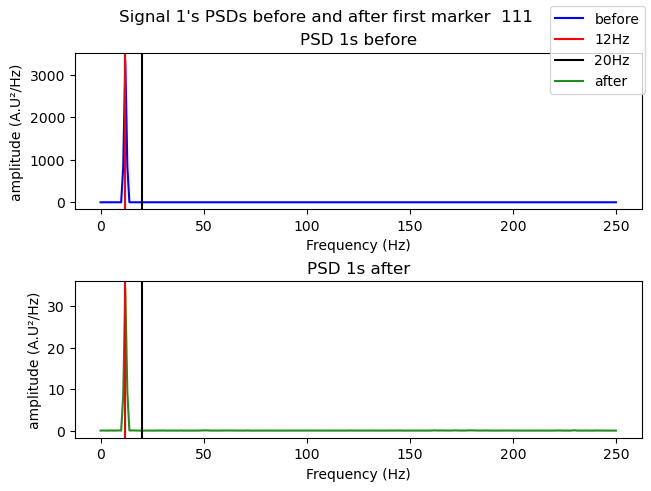

In [50]:
#Plot signal i's PSDs around selected marker 111
figure,axis=plt.subplots(2,num=4,layout="constrained")
figure.suptitle("Signal "+str(ELECTRODE_NUM)+"'s PSDs before and after first marker  111")
axis[0].set_title("PSD "+str(TIME_WINDOW) +"s before")
axis[0].set_ylabel("amplitude (A.U²/Hz)")
axis[0].set_xlabel("Frequency (Hz)")
axis[0].plot(tridi_freqs_before[:, 0, SELECTOR],tridi_Pxx_densities_111_before[:, marker_111_index, SELECTOR],color="blue",label="before")

axis[0].axvline(x=signal_frequency1,color="red",label=str(signal_frequency1)+"Hz")
axis[0].axvline(x=signal_frequency2,color="black",label=str(signal_frequency2)+"Hz")

axis[1].set_title("PSD "+str(TIME_WINDOW) +"s after")
axis[1].set_ylabel("amplitude (A.U²/Hz)")
axis[1].set_xlabel("Frequency (Hz)")
axis[1].plot(tridi_freqs_after[:, 0, SELECTOR],tridi_Pxx_densities_111_after[:, marker_111_index, SELECTOR],color="forestgreen",label="after")

axis[1].axvline(x=signal_frequency1,color="red",label="_"+str(signal_frequency1)+"Hz")
axis[1].axvline(x=signal_frequency2,color="black",label="_"+str(signal_frequency2)+"Hz")

figure.legend()


### Plot signal i's ERSP around 1st marker 111<a   name="ERSPplotold"></a>

In [51]:
# compute the ratio of the Pxx_densities of each side of each marker(12*2) of each of the 8 channel
# need (PSDafter-PSDbefore/PSDbefore)*100
tridi_Pxx_densities_ratio_111 = ((
    tridi_Pxx_densities_111_after-tridi_Pxx_densities_111_before)/tridi_Pxx_densities_111_before)*100
tridi_Pxx_densities_ratio_100 = ((
    tridi_Pxx_densities_100_before-tridi_Pxx_densities_111_after)/tridi_Pxx_densities_111_after)*100

if np.array_equal(tridi_freqs_after,tridi_freqs_before) :
    tridi_freqs_ratio=tridi_freqs_after

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


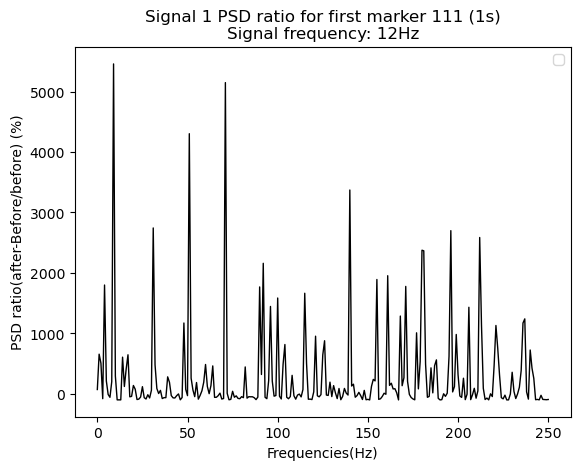

In [52]:
#Plot ERSP
single_plot("Signal frequency: "+str(eval("signal_frequency"+str(ELECTRODE_NUM)))+"Hz", fig_number=5, x=tridi_freqs_ratio[:, marker_111_index, SELECTOR], y=tridi_Pxx_densities_ratio_111[:, marker_111_index, SELECTOR],
            fig_title="Signal " +str(ELECTRODE_NUM)+ " PSD ratio for first marker 111 ("+str(TIME_WINDOW)+"s)",
            xlabel="Frequencies(Hz)", ylabel="PSD ratio(after-Before/before) (%)")


### Analysis<a   name="analysisold"></a>

Conclusion: Probleme données ratio reproduit. Persistant sur signal artificiel. 
Les PSD sont néamoins coherentes avec les caracteristiques des signaux generés.

Causes possibles: 
1. Elementwise operation: ecartée car fonctionne en soustraction (et syntaxe correcte)
2. Separation des matrices marqueurs 111 et 100, avant et apres: mauvaise selection?
3. Bug de la fonction nearest_timestamps_array_finder() qui associe a chaque temps de marqueur le temps le plus proche correspondant a un echantillion dans le signal.

Solution: revoir et simplifier la methode de calcul des PSD et de la variation relative de la puissance (ERSP)

## 2-PSD around markers and ratio calculation: New method<a   name="new"></a>

### Compute the PSDs around all markers for one signal<a   name="psdnew"></a>

In [53]:
# Segment length of the signal on which the PSD is computed (expressed in seconds)
TIME_WINDOW=4  #in seconds

In [54]:
#Compute the power spectrum on segments before and after all markers for selected electrode

#freqs, Pxx_density=compute_welch_estimation_on_segment2(segment=signal_electrodes[:,SELECTOR],sample_rate=Srate,nfft=len(signal_electrodes[:,SELECTOR])) #over whole signal
TIME_WINDOW#in seconds

before=compute_welch_on_a_signal_before_each_marker(signal_electrodes[:,SELECTOR], sample_rate=Srate, 
                                                  marker_times=nearest_marker_indices_timestamps, segment_duration=TIME_WINDOW) #over TIME_WINDOW sec before each marker

after=compute_welch_on_a_signal_after_each_marker(signal_electrodes[:,SELECTOR], sample_rate=Srate,  #over PSD_WINDOW sec after each marker
                                                  marker_times=nearest_marker_indices_timestamps, segment_duration=TIME_WINDOW)
baselines=compute_welch_on_a_signal_before_each_marker(signal_electrodes[:,SELECTOR], sample_rate=Srate,  #over 1sec after each
                                                  marker_times=nearest_marker_indices_timestamps, segment_duration=1)

print("before shape",len(before))
print("after shape",len(after))


before shape 2
after shape 2


### Select PSD results around selected marker for one signal<a   name="selectpsd"></a>

In [55]:
#Select marker n°
MARKER_NUMBER=2
MARKER_INDEX=MARKER_NUMBER-1 #cf python starts indexing at 0

In [56]:
#get the PSD results of the segments surrounding the selected marker
after_marker_n=after["PSD_magnitudes"][:,MARKER_INDEX]
before_marker_n=before["PSD_magnitudes"][:,MARKER_INDEX]
baseline=np.mean(baselines["PSD_magnitudes"][:,MARKER_INDEX])

#test to make sure the returned frequency vectors are the same on segments before and after the marker
test=np.unique(after["PSD_frequencies"]==before["PSD_frequencies"]) 
print(test)

if test[0] == True:
    PSD_freqs=after["PSD_frequencies"][:,1]


[ True]


### Plot signal i's PSDs around selected marker<a   name="psdplotnew"></a>

(251,)


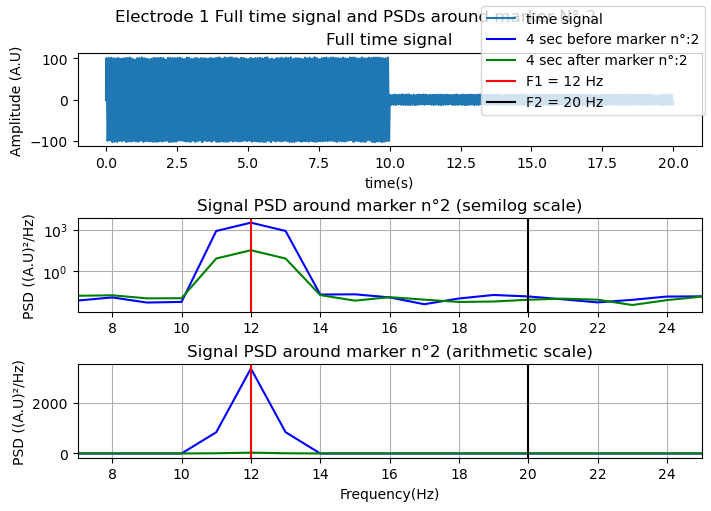

In [57]:
#Plot electrode i's time signal and PSDs around 1st marker 111
figure,axis=plt.subplots(3,1,num=6,figsize=(7, 5), layout="constrained")
figure.suptitle(f"Electrode {ELECTRODE_NUM} Full time signal and PSDs around marker N°:{MARKER_NUMBER}")

#Whole time-signal subplot
axis[0].set_title("Full time signal")
axis[0].plot(times,signal_electrodes[:,SELECTOR],label="time signal") #pic dirac pour la PSD sur l'ensemble du signal
axis[0].set_ylabel("Amplitude (A.U)")
axis[0].set_xlabel("time(s)")

#PSD before marker
axis[1].set_title(f"Signal PSD around marker n°{MARKER_NUMBER} (semilog scale)")
axis[1].semilogy(PSD_freqs,before_marker_n,"blue",label=str(TIME_WINDOW)+" sec before marker n°:"+str(MARKER_NUMBER))
axis[1].semilogy(PSD_freqs,after_marker_n,"green",label=str(TIME_WINDOW)+" sec after marker n°:"+str(MARKER_NUMBER))
axis[1].set_ylabel("PSD ((A.U)²/Hz)")
axis[1].set_xlim([min(signal_frequency1,signal_frequency2)-5,max(signal_frequency1,signal_frequency2)+5])

axis[1].axvline(x=signal_frequency1,color="red",label=f"F1 = {signal_frequency1} Hz")
axis[1].axvline(x=signal_frequency2,color="black",label=f"F2 = {signal_frequency2} Hz")

#PSD after marker
axis[2].set_title(f"Signal PSD around marker n°{MARKER_NUMBER} (arithmetic scale)")
axis[2].plot(PSD_freqs,before_marker_n,"blue",label="_"+str(TIME_WINDOW)+" sec before marker n°:"+str(MARKER_NUMBER))
axis[2].plot(PSD_freqs,after_marker_n,"green",label="_"+str(TIME_WINDOW)+" sec after marker n°:"+str(MARKER_NUMBER))
axis[2].set_ylabel("PSD ((A.U)²/Hz)")
axis[2].set_xlabel("Frequency(Hz)")

axis[2].set_xlim([min(signal_frequency1,signal_frequency2)-5,max(signal_frequency1,signal_frequency2)+5])

#Frequencies defined for signal generation
axis[2].axvline(x=signal_frequency1,color="red",label=f"_F1 = {signal_frequency1} Hz")
axis[2].axvline(x=signal_frequency2,color="black",label=f"_F2 = {signal_frequency2} Hz")

axis[1].grid()
axis[2].grid()
figure.legend(loc='upper right')
print(np.shape(PSD_freqs))

In [58]:
# What are the maximas of the power spectrum of the segments surrounding the 1st '111' marker?
maxima_psd_before=np.max(before_marker_n) #1st marker 111 (2d marker of all)
maxima_psd_after=np.max(after_marker_n) #1st marker 111 (2d marker of all)

#Can we see the amplitude switch on the power spectra? (cf original_amp_1 vs new_amp_1 )?
ratio_signal_amplitude=original_amp_1/new_amp_1
ratio_psd_maximas=maxima_psd_before/maxima_psd_after


print(f"maxima of the PSD over {TIME_WINDOW} sec before Marker 111:",maxima_psd_before) 
print(f"maxima of the PSD over {TIME_WINDOW} sec after Marker 111:",maxima_psd_after) 
print(f"ratio of the amplitudes of the two sections of the signal:",ratio_signal_amplitude) 
print(f"ratio of the PSD maximas over {TIME_WINDOW} sec on each side of the 1st Marker 111:",ratio_psd_maximas)

maxima of the PSD over 4 sec before Marker 111: 3335.2960526297934
maxima of the PSD over 4 sec after Marker 111: 33.47011876078714
ratio of the amplitudes of the two sections of the signal: 10.0
ratio of the PSD maximas over 4 sec on each side of the 1st Marker 111: 99.6499617006843


### Analysis 1<a   name="analysis1new"></a>

<u>Hyp1:</u> Since the energy carried out by a wave is proportional to the square of its amplitude, we expect that the ratio of energy between two sine wave is equal to the square of the ratio of their amplitude.
<br>Here integration time is the same so, ratio of power should be equal to the square of the amplitude ratio.


<u>Hyp2:</u> These maximas should be found at the signal frequency which is constant (ex: x=12Hz)

<u>CCL:</u> The result (cf above cell) is coherent with this hypothesis. We have indeed:
$$
\frac{PowerBefore}{PowerAfter}=(\frac{AmplitudeBefore}{AmplitudeAfter})²
$$

NB: We only change the amplitude of the signal at half duration, the frequency stays the same.


### Plot Signal i's ERSP around 1st marker 111<a   name="ERSPnew"></a>

In [59]:

round_button=True
if round_button:
    after_marker_n=np.around(after_marker_n, decimals=0, out=None)
    before_marker_n=np.around(before_marker_n, decimals=0, out=None)

diff_PSDs=np.subtract(after_marker_n,before_marker_n)

#ERSP formula
#diff_PSDs=np.round(diff_PSDs,decimals=2)

ratio_PSDs=np.divide(diff_PSDs,before_marker_n)*100 #returns nans if divided by 0
ratio_PSDs=np.nan_to_num(ratio_PSDs, copy=False, nan=0.0) #manage nan values

C:\Users\iWiss\AppData\Local\Temp\ipykernel_14096\2598452514.py:11: RuntimeWarning: invalid value encountered in divide
  ratio_PSDs=np.divide(diff_PSDs,before_marker_n)*100 #returns nans if divided by 0


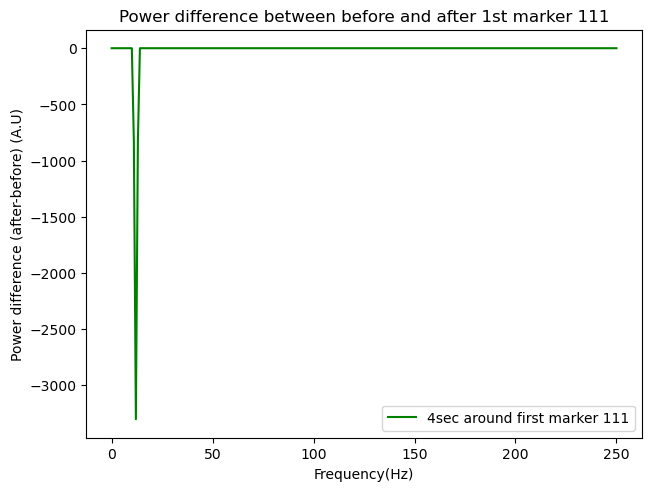

In [60]:
#Plot the difference between PSD after and before
figure,axis=plt.subplots(num=7,layout="constrained")
axis.plot(PSD_freqs,diff_PSDs,"-g",label="4sec around first marker 111") #pic dirac elargi a la base pour la PSD sur setion d'1sec du signal
#axis.axvline(12)
axis.set_title("Power difference between before and after 1st marker 111")
axis.set_ylabel("Power difference (after-before) (A.U)")
axis.set_xlabel("Frequency(Hz)")
axis.legend()
#axis.set_xlim([min(signal_frequency1,signal_frequency2)-5,max(signal_frequency1,signal_frequency2)+5])

(7.0, 25.0)

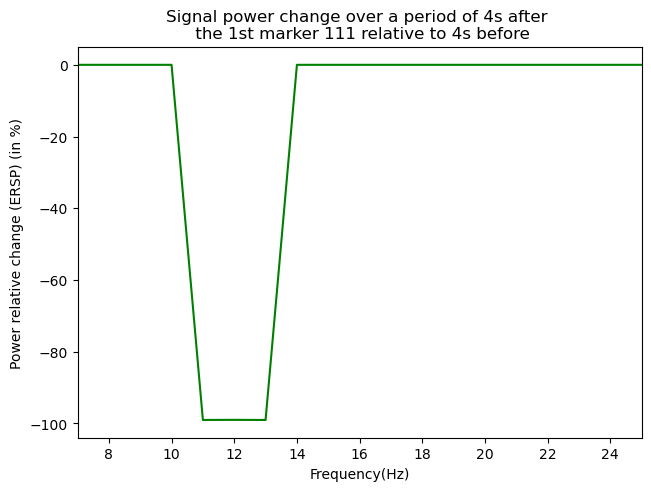

In [61]:
#Plot ERSP
figure,axis=plt.subplots(num=8,layout="constrained")
axis.plot(PSD_freqs,ratio_PSDs,"-g",label="4sec around first marker 111") #pic dirac elargi a la base pour la PSD sur setion d'1sec du signal
axis.set_title("Signal power change over a period of 4s after \n the 1st marker 111 relative to 4s before")
axis.set_ylabel("Power relative change (ERSP) (in %)")
axis.set_xlabel("Frequency(Hz)")
#axis.set_xlim([min(signal_frequency1,signal_frequency2)-5,max(signal_frequency1,signal_frequency2)+5])

### Analysis 2<a   name="analysis2new"></a>

Rappelons que le 1er marqueur 111 correspond uniquement au changement d'amplitude du signal. Et que le calcul des PSD est identique quel que soit le segment du signal sur lequel il est réalisé.
Ainsi en calculant la PSD sur un segment de taille identique (en nombre d'échantillons) avant et après le 1er marqueur 111, le seul paramètre changeant est l'amplitude de la sinusoïde.

On remarque dans le résultat des deux PSD qu'en plus d'avoir des valeurs de puissances autour de la fréquence du signal (spectral leakage ?) :
- Il existe des valeurs d'amplitude pour des fréquences qui en sont éloignées (pour f=12Hz, à 5Hz et 100Hz par exemple).
- On remarque aussi que ces puissances à des fréquences éloignées ne sont pas identiques. 

<u>CCL 1:</u> Alors qu'on s'attendait à des valeurs nulles à des fréquences éloignées, ce n'est pas le cas. <br><br>
<u>CCL 2:</u> Alors qu'on s'attendait à des valeurs identiques pour des fréquences non contenues dans le signal, ce n'est pas le cas.<br><br>
<u>CCL 3:</u> L'amplitude d'un signal de frequence unique impacte les valeurs de puissance même à des frequences non contenues dans celui ci.

Tout ceci fait que pour un signal de fréquence donné, même si les puissances avant et après le changement d'amplitude sont très proches, la formule de calcul des ERSP laisse au dénominateur des puissances négatives importantes. Cela se traduit en variations de puissance relative très élevées.

<u>CCL:</u> Le pb du calcul des ERSP semble donc résider dans le fait que la méthode de welch n'est pas parfaite.

<span style='color:yellow'> Quelle solution??</span >

